Using the data on student grades from this lesson, complete the following:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings("ignore")

import wrangle
import split_scale

In [2]:
grades = pd.read_csv("student_grades.csv")

**1. Split the data into train and test datasets.**

In [3]:
train, test = split_scale.split_my_data(grades)

In [4]:
train.head()

,student_id,exam1,exam2,exam3,final_grade
21,22,70.0,65,78,77
77,78,70.0,75,78,72
35,36,62.0,70,79,70
71,72,92.0,89,94,93
65,66,100.0,90,95,96


In [5]:
train.dtypes

student_id       int64
exam1          float64
exam2            int64
exam3           object
final_grade      int64
dtype: object

- I need to clean up exam_3 to be either an int or float

- Also need to either drop studen_id or set it as the index if it's unique

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 21 to 66
Data columns (total 5 columns):
student_id     72 non-null int64
exam1          72 non-null float64
exam2          72 non-null int64
exam3          72 non-null object
final_grade    72 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 3.4+ KB


In [7]:
train.exam3.value_counts(dropna=False)

78    13
96    12
75     8
86     6
85     6
79     6
95     6
94     5
70     5
87     4
       1
Name: exam3, dtype: int64

I see we are missing a value so I am going to replace it with nan and drop the row

In [8]:
train.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [9]:
train.exam3.value_counts(dropna=False)

78     13
96     12
75      8
85      6
86      6
79      6
95      6
94      5
70      5
87      4
NaN     1
Name: exam3, dtype: int64

In [10]:
train = train.dropna()

In [11]:
train.drop(columns="student_id", inplace=True)

In [12]:
train

,exam1,exam2,exam3,final_grade
21,70.0,65,78,77
77,70.0,75,78,72
35,62.0,70,79,70
71,92.0,89,94,93
65,100.0,90,95,96
...,...,...,...,...
83,79.0,70,85,81
17,93.0,90,96,97
98,73.0,70,75,76
92,98.0,93,96,95


In [13]:
train.exam3 = train.exam3.astype(int)

In [14]:
train.exam1 = train.exam1.astype(int)

In [15]:
train.dtypes

exam1          int64
exam2          int64
exam3          int64
final_grade    int64
dtype: object

**2. Create a model that uses exam 1 to predict the final grade.**

I'm going to create a prdeictions df to hold my model predictions with actual grades

In [16]:
predictions_df = pd.DataFrame({"actual": train.final_grade})

I'm going to create a baseline model before I move onto creating any other models

In [17]:
predictions_df['baseline'] = train.final_grade.mean()

In [18]:
predictions_df.head()

,actual,baseline
21,77,82.140845
77,72,82.140845
35,70,82.140845
71,93,82.140845
65,96,82.140845


In [19]:
import sklearn.linear_model

In [20]:
#X always needs to be 2D
X = train[["exam1"]]

In [21]:
y = train.final_grade

In [22]:
#1. make the thing
lm = sklearn.linear_model.LinearRegression()

In [23]:
#2. fit the thing
lm.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
#3 Use the thing and add to the df created
predictions_df["exam1_lm"] = lm.predict(X)


In [25]:
predictions_df.head()

,actual,baseline,exam1_lm
21,77,82.140845,75.384666
77,72,82.140845,75.384666
35,70,82.140845,69.388558
71,93,82.140845,91.873965
65,96,82.140845,97.870074


In [26]:
lm.coef_, lm.intercept_

(array([0.74951359]), 22.918715037628445)

In [27]:
print('final_grade = {:.3f} * exam1 + {:.3f}'.format(lm.coef_[0], lm.intercept_))

final_grade = 0.750 * exam1 + 22.919


**2. Create a model that uses exam 2 to predict the final grade.**

In [28]:
X2 = train[["exam2"]]
y2 = train.final_grade

In [29]:
# 1. Make the thing
lm2 = sklearn.linear_model.LinearRegression()

In [31]:
# 2. fit the thing
lm2.fit(X2,y2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
# 3. Use the thing and add to the df
predictions_df["exam2_lm"] = lm2.predict(X2)

In [33]:
predictions_df.head()

,actual,baseline,exam1_lm,exam2_lm
21,77,82.140845,75.384666,70.143566
77,72,82.140845,75.384666,79.714429
35,70,82.140845,69.388558,74.928998
71,93,82.140845,91.873965,93.113637
65,96,82.140845,97.870074,94.070723


In [34]:
lm2.coef_, lm2.intercept_

(array([0.95708627]), 7.932958919904024)

In [35]:
print('final_grade = {:.3f} * exam2 + {:.3f}'.format(lm2.coef_[0], lm2.intercept_))

final_grade = 0.957 * exam2 + 7.933


**4. Compare your models in the following manner**

**- Calculate the mean squared error**

In [37]:
import sklearn.metrics

In [39]:
predictions_df.apply(lambda col: sklearn.metrics.mean_squared_error(predictions_df.actual, col))

actual        0.000000
baseline    115.811149
exam1_lm      3.892311
exam2_lm     18.098735
dtype: float64

**-Visualize the residuals. Create a seperate visualization for each model.**

In [40]:
def plot_residuals_simple_1(y, yhat, color="tab:cyan"):
    residuals = y - yhat
    plt.scatter(y, residuals, color=color)
    return plt.gca

In [47]:
def plot_residuals_simple(actual, predicted):
    residuals = actual - predicted
    plt.hlines(0, actual.min(), actual.max(), ls=':')
    plt.scatter(actual, residuals)
    plt.ylabel('residual ($y - \hat{y}$)')
    plt.xlabel('actual value ($y$)')
    return plt.gca()

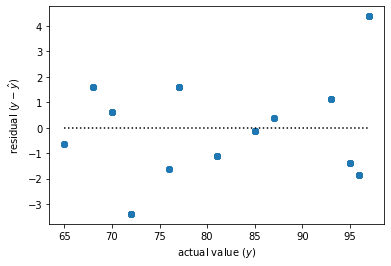

In [48]:
plot_residuals_simple(predictions_df.actual, predictions_df.exam1_lm)

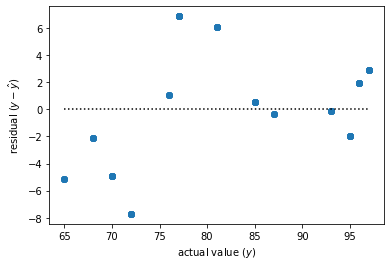

In [49]:
plot_residuals_simple(predictions_df.actual, predictions_df.exam2_lm)

**- Visualize the actual vs the predicted values. Create a seperate visualization for each model.**


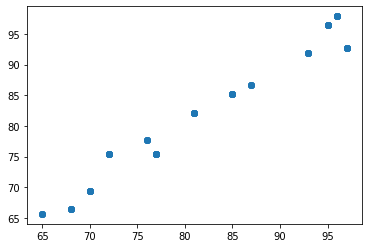

In [52]:
plt.scatter(predictions_df.actual, predictions_df.exam1_lm, label='LinearRegression (final_grade ~ exam1)', marker='o')

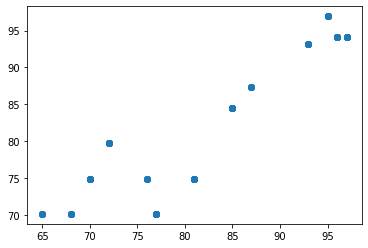

In [53]:
plt.scatter(predictions_df.actual, predictions_df.exam2_lm, label='LinearRegression (final_grade ~ exam2)', marker='o')

**Bonus: Combine the seperate visualizations for each model into a single visualization. Is this visual helpful?**

Text(0.5, 1.0, 'Predicted vs Actual Final Grade')

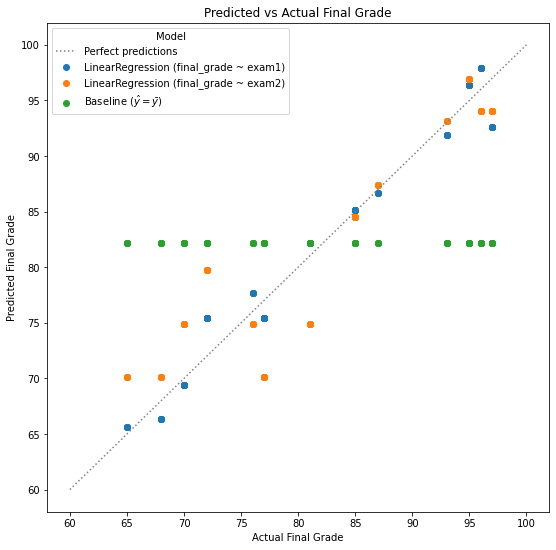

In [51]:
plt.figure(figsize=(9, 9))

plt.scatter(predictions_df.actual, predictions_df.exam1_lm, label='LinearRegression (final_grade ~ exam1)', marker='o')
plt.scatter(predictions_df.actual, predictions_df.exam2_lm, label='LinearRegression (final_grade ~ exam2)', marker='o')
plt.scatter(predictions_df.actual, predictions_df.baseline, label=r'Baseline ($\hat{y} = \bar{y}$)', marker='o')
plt.plot([60, 100], [60, 100], label='Perfect predictions', ls=':', c='grey')

plt.legend(title='Model')
plt.ylabel('Predicted Final Grade')
plt.xlabel('Actual Final Grade')
plt.title('Predicted vs Actual Final Grade')

**5. Create a model that uses exam 1 and exam 3 to predict final grade. How does this model compare to your previous ones?**

In [54]:
X3 = train[["exam1", "exam3"]]
y3 = train.final_grade

In [55]:
# 1. make the thing
lm3 = sklearn.linear_model.LinearRegression()

In [56]:
# 2. fit the thing
lm3.fit(X3, y3)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
# 3. use the thing
predictions_df["exams_1_and_3_lm"] = lm3.predict(X3)

In [59]:
predictions_df.sample(4)

,actual,baseline,exam1_lm,exam2_lm,exams_1_and_3_lm
2,87,82.140845,86.627370,87.371119,86.290382
40,95,82.140845,96.371047,96.941982,96.500828
43,97,82.140845,92.623479,94.070723,93.692620
35,70,82.140845,69.388558,74.928998,70.786755


In [61]:
lm3.coef_, lm.intercept_

(array([0.56164153, 0.32323397]), 22.918715037628445)

In [62]:
predictions_df.apply(lambda col: sklearn.metrics.mean_squared_error(predictions_df.actual, col))

actual                0.000000
baseline            115.811149
exam1_lm              3.892311
exam2_lm             18.098735
exams_1_and_3_lm      3.208112
dtype: float64

In [79]:
mse_1_3 = sklearn.metrics.mean_squared_error(predictions_df.actual, predictions_df.exams_1_and_3_lm)

In [81]:
rmse_1_3 = math.sqrt(mse_1_3)
rmse_1_3

1.7911203012810004

**6. Take your best preforming model and measure its performance on the test data set. How does performance differ between train and test?**

In [65]:
#need to clean this data just like ai did the train data
test.sample(4)

,student_id,exam1,exam2,exam3,final_grade
62,63,58.0,65,70,68
87,88,62.0,70,79,70
63,64,57.0,65,75,65
31,32,79.0,70,85,81


In [66]:
test.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [67]:
test = test.dropna()

In [68]:
test = test.astype(int)

In [69]:
test.dtypes

student_id     int64
exam1          int64
exam2          int64
exam3          int64
final_grade    int64
dtype: object

In [70]:
test.drop(columns="student_id", inplace=True)

In [71]:
test.sample(4)

,exam1,exam2,exam3,final_grade
31,79,70,85,81
93,85,83,87,87
13,100,90,95,96
50,57,65,75,65


In [ ]:
#recreate our best performing model
X3 = train[["exam1", "exam3"]]
y3 = train.final_grade

# 1. make the thing
lm3 = sklearn.linear_model.LinearRegression()

# 2. fit the thing
lm3.fit(X3, y3)
# 3. use the thing
predictions_df["exams_1_and_3_lm"] = lm3.predict(X3)

In [74]:
X_test = test[["exam1", "exam3"]]
test_actuals = test.final_grade

In [75]:
test_predictions = lm3.predict(X_test)

In [76]:
mse = sklearn.metrics.mean_squared_error(test_actuals, test_predictions)

In [77]:
import math

In [78]:
rmse = math.sqrt(mse)
rmse

1.645535287439677

### Our scenario continues:

As a customer analyst, I want to know who has spent the most money with us over their lifetime. I have monthly charges and tenure, so I think I will be able to use those two attributes as features to estimate total_charges. I need to do this within an average of $5.00 per customer.

**1. Run all your previous scripts that acquired, prepared, split, and scaled the telco churn data.**

In [82]:
df = wrangle.wrangle_telco()

In [83]:
train, test = split_scale.split_my_data(df)

In [84]:
train.sample(4)

,customer_id,tenure,monthly_charges,total_charges
908,5480-XTFFL,31,21.00,697.70
639,3836-FZSDJ,71,24.85,1901.00
334,2075-PUEPR,55,19.35,1153.25
186,1095-WGNGG,61,101.05,5971.25


In [85]:
train.drop(columns="customer_id", inplace=True)

In [86]:
train.head()

,tenure,monthly_charges,total_charges
555,70,115.15,8250.00
1518,36,25.10,930.95
1498,63,19.25,1237.65
1157,60,84.95,4984.85
1458,18,25.30,454.65


**2. Fit 3 different linear models to your data, one with just tenure, one with just monthly_charges, and one with both.**

In [92]:
predictions = pd.DataFrame({"actual": train.total_charges})

In [87]:
X1 = train[["tenure"]]
y = train.total_charges

In [89]:
lm1 = sklearn.linear_model.LinearRegression()

In [90]:
lm1.fit(X1, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [93]:
predictions["tenure_lm"] = lm1.predict(X1)

In [94]:
predictions.sample(4)

,actual,tenure_lm
6,2560.1,3628.428252
1141,6428.4,4094.461226
37,6717.9,4653.700796
454,6997.3,4374.081011


In [96]:
lm1.coef_, lm1.intercept_

(array([93.20659496]), -1591.1410659326625)

In [102]:
rmse_tenure = math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.tenure_lm))

In [103]:
rmse_tenure

1994.8797955702055

In [104]:
X2 = train[["monthly_charges"]]

In [105]:
lm2 = sklearn.linear_model.LinearRegression()

In [106]:
lm2.fit(X2, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [107]:
predictions["monthly_charges_lm"] = lm2.predict(X2)

In [108]:
predictions.sample(4)

,actual,tenure_lm,monthly_charges_lm
422,4504.90,4933.320581,3997.742024
1476,5574.35,5026.527176,4908.845850
514,5175.30,4094.461226,5532.601546
1212,7711.25,4933.320581,7530.021471


In [111]:
lm2.coef_, lm2.intercept_

(array([70.08490965]), -526.2388940644619)

In [109]:
rmse_monthly_charges = math.sqrt(sklearn.metrics.mean_squared_error(predictions.actual, predictions.monthly_charges_lm))

In [110]:
rmse_monthly_charges

828.1289279523282

In [112]:
X3 = train[["monthly_charges", "tenure"]]

In [113]:
lm3 = sklearn.linear_model.LinearRegression()

In [114]:
lm3.fit(X3, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [115]:
predictions["monthly_and_tenure_lm"] = lm3.predict(X3)

In [116]:
lm3.coef_, lm3.intercept_

(array([61.21838363, 42.26165827]), -2406.4333672675143)

In [117]:
monthly_and_tenure_mse = sklearn.metrics.mean_squared_error(predictions.actual, predictions.monthly_and_tenure_lm)

In [118]:
monthly_and_tenure_rse = math.sqrt(monthly_and_tenure_mse)

In [119]:
monthly_and_tenure_rse

485.81867952604773

In [126]:
train.head()

,tenure,monthly_charges,total_charges
555,70,115.15,8250.00
1518,36,25.10,930.95
1498,63,19.25,1237.65
1157,60,84.95,4984.85
1458,18,25.30,454.65


In [128]:
predictions['baseline'] = train.total_charges.mean()

In [129]:
baseline_mse = sklearn.metrics.mean_squared_error(predictions.actual, predictions.baseline)

In [130]:
baseline_rmse = math.sqrt(baseline_mse)

In [131]:
baseline_rmse

2574.889898553265

In [133]:
test.drop(columns="customer_id")

,tenure,monthly_charges,total_charges
305,72,20.50,1502.25
452,67,111.30,7567.20
917,63,109.20,7049.75
1421,64,19.45,1225.65
1557,24,24.10,587.40
...,...,...,...
1546,72,81.00,5750.00
1525,45,84.35,3858.05
271,71,25.45,1789.65
913,47,20.15,1046.20
